In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import re
from sentence_transformers import SentenceTransformer, util
import time
import torch
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

In [2]:
%%time
# @formatter:on

df = pd.read_parquet(path = './data/retail-clean-v1.parquet', engine = 'pyarrow')
n_rows = len(df.index)
n_cols = len(df.columns)
print(f"Dataframe length is: {len(df.index)}")
print(f"Portion of dataframe that is removed so far: {(n_rows - len(df.index)) / n_rows * 100:.2f}%")
print(f"Number of columns is: {len(df.columns)}")

display(df.dtypes)


def null_val_summary(df):
    null_info = pd.DataFrame(df.dtypes).T.rename(index = {0: 'column type'})
    null_info = null_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index = {0: 'null values (nb)'}))
    null_info = null_info.append(pd.DataFrame(df.isnull().sum() / n_rows * 100).T.rename(index = {0: 'null values (%)'}))
    display(null_info)


def unique_col_percent(df):
    for col in df.columns:
        print(f"{col} unique count and percentage: {len(df[col].unique())}, {len(df[col].unique()) / n_rows * 100:0.2f}")


unique_col_percent(df = df)
null_val_summary(df = df)
df.head()

Dataframe length is: 529071
Portion of dataframe that is removed so far: 0.00%
Number of columns is: 11


InvoiceNo                string
StockCode                string
Description              string
Quantity                  int64
InvoiceDate      datetime64[ns]
UnitPrice               float64
CustomerID                int64
Country                  string
InvoiceNoNum              int64
StockCodeNum              int64
StockCodeChar            string
dtype: object

InvoiceNo unique count and percentage: 20545, 3.88
StockCode unique count and percentage: 3819, 0.72
Description unique count and percentage: 4051, 0.77
Quantity unique count and percentage: 391, 0.07
InvoiceDate unique count and percentage: 18892, 3.57
UnitPrice unique count and percentage: 503, 0.10
CustomerID unique count and percentage: 4336, 0.82
Country unique count and percentage: 38, 0.01
InvoiceNoNum unique count and percentage: 20545, 3.88
StockCodeNum unique count and percentage: 3303, 0.62
StockCodeChar unique count and percentage: 28, 0.01


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string
null values (nb),0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 1.2 s


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,536365,85123,a
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,71053,
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,536365,84406,b
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,84029,g
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,84029,e


white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1399
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: Description, dtype: Int64

jumbo bag vintage christmas           489
set of 3 wooden heart decorations     487
vintage union jack bunting            487
doormat spotty home sweet home        486
small heart measuring spoons          485
set/3 red gingham rose storage box    482
ladies & gentlemen metal sign         481
feltcraft cushion owl                 480
party metal sign                      480
3 stripey mice feltcraft              479
Name: Description, dtype: Int64

pink allium  artificial flower        1
black cherry lights                   1
incense bazaar peach                  1
ocean stripe hammock                  1
ooh la la dogs collar                 1
easter craft ivy wreath with chick    1
tiny crystal bracelet red             1
pink cherry blossom cup & saucer      1
peg bag apple design                  1
paper craft , little birdie           1
Name: Description, dtype: Int64

Wall time: 1.59 s


<BarContainer object of 20 artists>

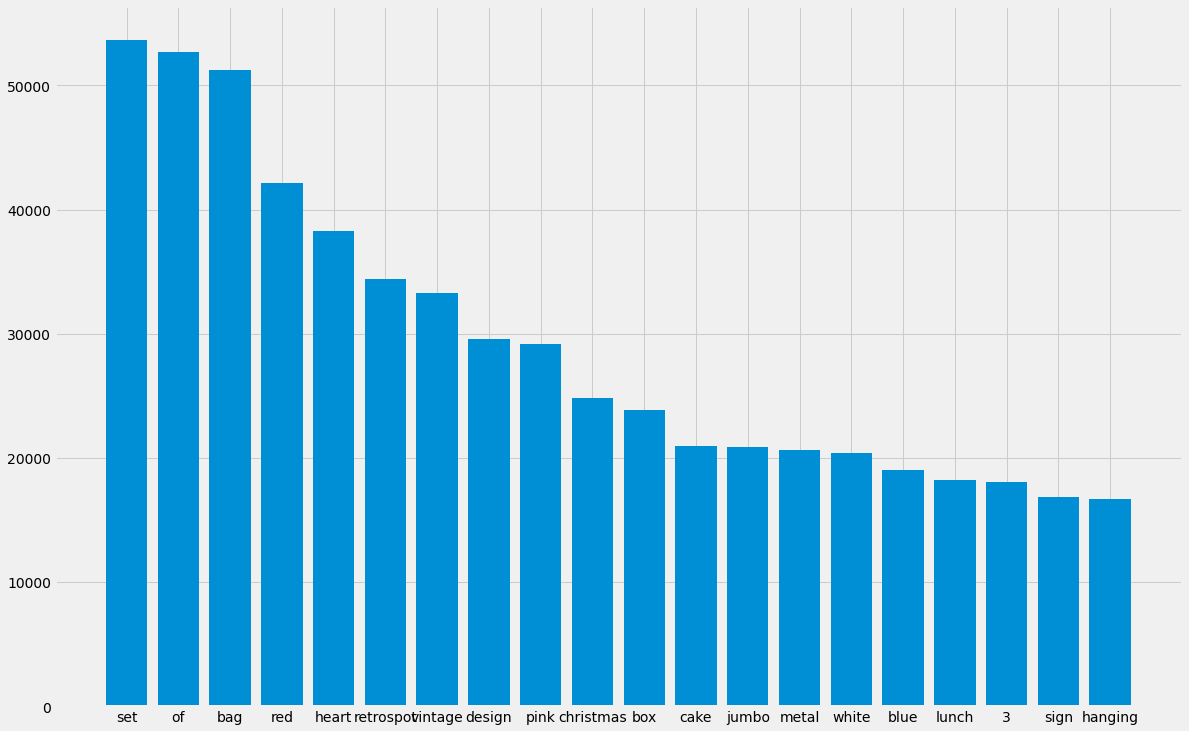

In [3]:
%%time
# @formatter:on

display(df['Description'].value_counts(dropna = False)[:10])
display(df['Description'].value_counts(dropna = False)[200:210])
display(df['Description'].value_counts(dropna = False)[-10:])

w = dict(Counter([i for j in df['Description'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (18, 12))
plt.bar(w.keys(), w.values())

In [4]:
%%time
# @formatter:on

# Remove cases
# ----- Expected output -----
# Before: THIS TEXT WILL BE LOWERCASED. THIS too: ßßß
# After: this text will be lowercased. this too: ssssss
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy
def case_folder(text):
    return text.casefold()


df['DescriptionEdited'] = df['Description'].apply(lambda x: case_folder(x))
display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['Description'])])
print(f"unique values: {len(df['DescriptionEdited'].unique())}")

white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1399
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: DescriptionEdited, dtype: int64

jumbo bag vintage christmas           489
set of 3 wooden heart decorations     487
vintage union jack bunting            487
doormat spotty home sweet home        486
small heart measuring spoons          485
set/3 red gingham rose storage box    482
ladies & gentlemen metal sign         481
feltcraft cushion owl                 480
party metal sign                      480
3 stripey mice feltcraft              479
Name: DescriptionEdited, dtype: int64

16 pc cutlery set pantry design        1
lily brooch white/silver colour        1
on cargo order                         1
pearl & shell 42"neckl. ivory          1
zinc plant pot holder                  1
ivory pantry hanging lamp              1
crystal chandelier t-light holder      1
food cover with beads , set 2 sizes    1
polyester filler pad 60x40cm           1
paper craft , little birdie            1
Name: DescriptionEdited, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited


unique values: 4051
Wall time: 433 ms


In [5]:
%%time
# @formatter:on

# removing numbers
# ----- Expected output -----
# Before: Remove these numbers: 1919191 2229292 11.233 22/22/22.
# After: Remove these numbers: .//.
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy

def remove_number(text):
    #return re.sub(r"\b[0-9]+\b\s*", " ", text)
    return ''.join([i for i in text if not i.isdigit()])


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_number(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values: {len(df['DescriptionEdited'].unique())}")

white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1399
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

pantry magnetic  shopping list       489
jumbo bag vintage christmas          489
lunch box with cutlery retrospot     489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
set/ red gingham rose storage box    482
ladies & gentlemen metal sign        481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

scallop shell soap dish               1
vintage bead pink jewel stand         1
miseltoe heart wreath cream           1
necklace+bracelet set pink daisy      1
pink chrysanthemums art flower        1
wall art , the magic forest           1
doorknob ceramic ivory                1
heavens scent fragrance oils asstd    1
blue monte carlo handbag              1
paper craft , little birdie           1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,536365,22752,,set 7 babushka nesting boxes,set babushka nesting boxes
14,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,536367,84969,,box of 6 assorted colour teaspoons,box of assorted colour teaspoons
40,536370,22900,set 2 tea towels i love london,24,2010-12-01 08:45:00,2.95,12583,France,536370,22900,,set 2 tea towels i love london,set tea towels i love london
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,France,536370,22326,,round snack boxes set of4 woodland,round snack boxes set of woodland
33,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,France,536370,21035,,set/2 red retrospot tea towels,set/ red retrospot tea towels
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541883,581585,84692,box of 24 cocktail parasols,25,2011-12-09 12:31:00,0.42,15804,United Kingdom,581585,84692,,box of 24 cocktail parasols,box of cocktail parasols
541882,581585,21916,set 12 retro white chalk sticks,24,2011-12-09 12:31:00,0.42,15804,United Kingdom,581585,21916,,set 12 retro white chalk sticks,set retro white chalk sticks
541891,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,581586,23275,,set of 3 hanging owls ollie beak,set of hanging owls ollie beak
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,581587,22613,,pack of 20 spaceboy napkins,pack of spaceboy napkins


unique values: 3991
Wall time: 1.47 s


In [6]:
%%time
# @formatter:on

# removing possessive and verb s
def remove_possessive(text):
    return text.replace("'s", '')


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_possessive(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values: {len(df['DescriptionEdited'].unique())}")


white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1399
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

pantry magnetic  shopping list       489
jumbo bag vintage christmas          489
lunch box with cutlery retrospot     489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
set/ red gingham rose storage box    482
ladies & gentlemen metal sign        481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

scallop shell soap dish               1
vintage bead pink jewel stand         1
miseltoe heart wreath cream           1
necklace+bracelet set pink daisy      1
pink chrysanthemums art flower        1
wall art , the magic forest           1
doorknob ceramic ivory                1
heavens scent fragrance oils asstd    1
blue monte carlo handbag              1
paper craft , little birdie           1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp
11,536367,22748,poppy's playhouse kitchen,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,536367,22748,,poppy's playhouse kitchen,poppy playhouse kitchen
10,536367,22745,poppy's playhouse bedroom,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,536367,22745,,poppy's playhouse bedroom,poppy playhouse bedroom
46,536371,22086,paper chain kit 50's christmas,80,2010-12-01 09:00:00,2.55,13748,United Kingdom,536371,22086,,paper chain kit 's christmas,paper chain kit christmas
122,536381,22086,paper chain kit 50's christmas,4,2010-12-01 09:41:00,2.95,15311,United Kingdom,536381,22086,,paper chain kit 's christmas,paper chain kit christmas
382,536402,22086,paper chain kit 50's christmas,40,2010-12-01 11:22:00,2.55,15513,United Kingdom,536402,22086,,paper chain kit 's christmas,paper chain kit christmas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541659,581538,22899,children's apron dolly girl,2,2011-12-09 11:34:00,2.10,14446,United Kingdom,581538,22899,,children's apron dolly girl,children apron dolly girl
541834,581579,23344,jumbo bag 50's christmas,20,2011-12-09 12:19:00,1.79,17581,United Kingdom,581579,23344,,jumbo bag 's christmas,jumbo bag christmas
541818,581579,22086,paper chain kit 50's christmas,12,2011-12-09 12:19:00,2.95,17581,United Kingdom,581579,22086,,paper chain kit 's christmas,paper chain kit christmas
541815,581579,23319,box of 6 mini 50's crackers,12,2011-12-09 12:19:00,2.49,17581,United Kingdom,581579,23319,,box of mini 's crackers,box of mini crackers


unique values: 3991
Wall time: 423 ms


In [7]:
%%time
# @formatter:on

# removing special characters
# ----- Expected output -----
# Before: Sample text 123 !!!! Haha.... !!!! ##$$$%%%%
# After: Sample text 123  Haha
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy

def remove_special_char(text):
    return re.sub(r"[^A-Za-z0-9\s]+", "", text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_special_char(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values: {len(df['DescriptionEdited'].unique())}")

white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
lunch bag red retrospot              1594
assorted colour bird ornament        1489
french blue metal door sign          1488
set of  cake tins pantry design      1399
pack of  retrospot cake cases        1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
pantry magnetic  shopping list      489
vintage union jack bunting          487
set of  wooden heart decorations    487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
set  colour pencils spaceboy        481
ladies  gentlemen metal sign        481
Name: DescriptionEditedTemp, dtype: int64

i love london mini rucksack            1
red rose and lace ccover               1
funky monkey mug                       1
wall artonly one person                1
marie antoienett trinket box gold      1
orangefuschia stones necklace          1
black glassshellpearl necklace         1
did  a credit  and did not tick ret    1
blue padded soft mobile                1
paper craft  little birdie             1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,536365,85123,a,white hanging heart t-light holder,white hanging heart tlight holder
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,84029,e,red woolly hottie white heart.,red woolly hottie white heart
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,536365,21730,,glass star frosted t-light holder,glass star frosted tlight holder
33,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,France,536370,21035,,set/ red retrospot tea towels,set red retrospot tea towels
64,536373,21730,glass star frosted t-light holder,6,2010-12-01 09:02:00,4.25,17850,United Kingdom,536373,21730,,glass star frosted t-light holder,glass star frosted tlight holder
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541868,581584,85038,6 chocolate love heart t-lights,48,2011-12-09 12:25:00,1.85,13777,United Kingdom,581584,85038,,chocolate love heart t-lights,chocolate love heart tlights
541888,581585,23145,zinc t-light holder star large,12,2011-12-09 12:31:00,0.95,15804,United Kingdom,581585,23145,,zinc t-light holder star large,zinc tlight holder star large
541884,581585,84946,antique silver t-light glass,12,2011-12-09 12:31:00,1.25,15804,United Kingdom,581585,84946,,antique silver t-light glass,antique silver tlight glass
541876,581585,84945,multi colour silver t-light holder,24,2011-12-09 12:31:00,0.85,15804,United Kingdom,581585,84945,,multi colour silver t-light holder,multi colour silver tlight holder


unique values: 3979
Wall time: 1.04 s


In [8]:
%%time
# @formatter:on

# removing words with less than 3 character

def remove_short_word(text):
    return re.sub(r'\b\w{1,2}\b', '', text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_short_word(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values: {len(df['DescriptionEdited'].unique())}")

white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set   cake tins pantry design        1399
pack   retrospot cake cases          1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

red retrospot peg bag               493
pantry magnetic  shopping list      489
jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
set   wooden heart decorations      487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
ladies  gentlemen metal sign        481
Name: DescriptionEditedTemp, dtype: int64

scallop shell soap dish              1
travel card wallet dotcomgiftshop    1
green with metal bag charm           1
garland magic garden                 1
bluenat shell necklace  pendant      1
white with metal bag charm           1
pink allium  artificial flower       1
black cherry lights                  1
mcolour pompom curtain               1
paper craft  little birdie           1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp
15,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,United Kingdom,536367,22623,,box of vintage jigsaw blocks,box vintage jigsaw blocks
14,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,536367,84969,,box of assorted colour teaspoons,box assorted colour teaspoons
16,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,United Kingdom,536367,22622,,box of vintage alphabet blocks,box vintage alphabet blocks
40,536370,22900,set 2 tea towels i love london,24,2010-12-01 08:45:00,2.95,12583,France,536370,22900,,set tea towels i love london,set tea towels love london
36,536370,22659,lunch box i love london,24,2010-12-01 08:45:00,1.95,12583,France,536370,22659,,lunch box i love london,lunch box love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541883,581585,84692,box of 24 cocktail parasols,25,2011-12-09 12:31:00,0.42,15804,United Kingdom,581585,84692,,box of cocktail parasols,box cocktail parasols
541891,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,581586,23275,,set of hanging owls ollie beak,set hanging owls ollie beak
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,581587,22613,,pack of spaceboy napkins,pack spaceboy napkins
541896,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,France,581587,22555,,plasters in tin strongman,plasters tin strongman


unique values: 3946
Wall time: 1.23 s


In [9]:
%%time
# @formatter:on

# removing extra whitespaces

def remove_extra_whitespace_tabs(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_extra_whitespace_tabs(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values: {len(df['DescriptionEdited'].unique())}")

white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1399
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEditedTemp, dtype: int64

red retrospot peg bag               493
lunch box with cutlery retrospot    489
jumbo bag vintage christmas         489
pantry magnetic shopping list       489
set wooden heart decorations        487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
ladies gentlemen metal sign         481
Name: DescriptionEditedTemp, dtype: int64

add stock allocate online orders    1
for online retail orders            1
damaged                             1
found whse                          1
website fixed                       1
flower fairy summer draw liners     1
pink dolly hair clips               1
large round cutglass candlestick    1
camouflage dog collar               1
paper craft little birdie           1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,536365,22752,,set babushka nesting boxes,set babushka nesting boxes
15,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,United Kingdom,536367,22623,,box vintage jigsaw blocks,box vintage jigsaw blocks
14,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,536367,84969,,box assorted colour teaspoons,box assorted colour teaspoons
16,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,United Kingdom,536367,22622,,box vintage alphabet blocks,box vintage alphabet blocks
40,536370,22900,set 2 tea towels i love london,24,2010-12-01 08:45:00,2.95,12583,France,536370,22900,,set tea towels love london,set tea towels love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541891,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,581586,23275,,set hanging owls ollie beak,set hanging owls ollie beak
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,581587,22613,,pack spaceboy napkins,pack spaceboy napkins
541896,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,France,581587,22555,,plasters tin strongman,plasters tin strongman
541895,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,France,581587,22556,,plasters tin circus parade,plasters tin circus parade


unique values: 3932
Wall time: 1.83 s


In [10]:
%%time
# @formatter:on

display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])


white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1399
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEdited, dtype: int64

red retrospot peg bag               493
lunch box with cutlery retrospot    489
jumbo bag vintage christmas         489
pantry magnetic shopping list       489
set wooden heart decorations        487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
ladies gentlemen metal sign         481
Name: DescriptionEdited, dtype: int64

add stock allocate online orders    1
for online retail orders            1
damaged                             1
found whse                          1
website fixed                       1
flower fairy summer draw liners     1
pink dolly hair clips               1
large round cutglass candlestick    1
camouflage dog collar               1
paper craft little birdie           1
Name: DescriptionEdited, dtype: int64

Wall time: 168 ms


In [11]:
%%time
# @formatter:on

# python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md", disable = ['parser', 'ner'])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']
Wall time: 1.17 s


In [12]:
%%time
# @formatter:on

unique_desc = list(df['DescriptionEdited'].unique())

# New stop words list
customize_stop_words = [
    'alice blue', 'antique white',
    'aqua', 'aquamarine',
    'azure', 'beige',
    'bisque', 'black',
    'blanched almond', 'blue',
    'blue violet', 'brown',
    'burly wood', 'cadet blue',
    'chartreuse', 'chocolate',
    'coral', 'cornflower blue',
    'cornsilk', 'crimson',
    'cyan', 'dark blue',
    'dark cyan', 'dark golden rod',
    'dark gray', 'dark grey',
    'dark green', 'dark khaki',
    'dark magenta', 'dark olive green',
    'dark orange', 'dark orchid',
    'dark red', 'dark salmon',
    'dark sea green', 'dark slate blue',
    'dark slate gray', 'dark slate grey',
    'dark turquoise', 'dark violet',
    'deep pink', 'deep sky blue',
    'dim gray', 'dim grey',
    'dodger blue', 'fire brick',
    'floral white', 'forest green',
    'fuchsia', 'gainsboro',
    'ghost white', 'gold',
    'golden rod', 'gray',
    'grey', 'green',
    'green yellow', 'honey dew',
    'hot pink', 'indian red',
    'indigo', 'ivory',
    'khaki', 'lavender',
    'lavender blush', 'lawn green',
    'lemon chiffon', 'light blue',
    'light coral', 'light cyan',
    'light golden rod yellow',
    'light gray', 'light grey',
    'light green', 'light pink',
    'light salmon', 'light sea green',
    'light sky blue', 'light slate gray',
    'light slate grey', 'light steel blue',
    'light yellow', 'lime',
    'lime green', 'linen',
    'magenta', 'maroon',
    'medium aqua marine', 'medium blue',
    'medium orchid', 'medium purple',
    'medium sea green', 'medium slate blue',
    'medium spring green', 'medium turquoise',
    'medium violet red', 'midnight blue',
    'mint cream', 'misty rose', 'moccasin',
    'navajo white', 'navy',
    'old lace', 'olive',
    'olive drab', 'orange',
    'orange red', 'orchid',
    'pale golden rod', 'pale green',
    'pale turquoise', 'pale violet red',
    'papaya whip', 'peach puff',
    'peru', 'pink',
    'plum', 'powder blue',
    'purple', 'rebecca purple',
    'red', 'rosy brown',
    'royal blue', 'saddle brown',
    'salmon', 'sandy brown',
    'sea green', 'sea shell',
    'sienna', 'sky blue',
    'slate blue', 'slate gray',
    'slate grey', 'snow',
    'spring green', 'steel blue',
    'tan', 'teal',
    'thistle', 'tomato',
    'turquoise', 'violet',
    'wheat', 'white',
    'white smoke', 'yellow',
    'yellow green',

    #, 'silver'
    'set',

    'medium',
    'small', 'large',
    'giant',

    'wrongly code'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

res = []
for doc in tqdm(nlp.pipe(unique_desc, n_process = 2)):
    res.append(" ".join(token.lemma_ for token in doc if not token.is_stop))

for inx, item in enumerate(tqdm(unique_desc)):
    df.loc[df[df['DescriptionEdited'] == item].index, 'DescriptionEditedTemp'] = res[inx]

display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values: {len(df['DescriptionEdited'].unique())}")

3932it [00:12, 326.70it/s] 
100%|██████████| 3932/3932 [03:46<00:00, 17.37it/s]


alarm clock bakelike        4338
heart wicker                3407
hang heart tlight holder    3163
jumbo bag retrospot         2115
regency cakestand tier      2019
regency teacup saucer       1837
party bunting               1707
french metal door sign      1653
lunch bag retrospot         1594
spot ceramic drawer knob    1551
Name: DescriptionEditedTemp, dtype: int64

spotty paper plate             532
cream heart card holder        531
kids cookie cutter             531
suki shoulder bag              531
plaster tin strongman          530
spaceboy birthday card         530
pack london tissue             529
cream sweetheart mini chest    529
airline bag vintage jet        528
jumbo bag toy                  525
Name: DescriptionEditedTemp, dtype: int64

lily brooch whitesilver colour     1
vintage tinsel reel                1
jardin etch glass butter dish      1
mcolour pompom curtain             1
cargo order                        1
paint heart wreath bell            1
allocate stock dotcom order        1
add stock allocate online order    1
online retail order                1
paper craft little birdie          1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,536365,85123,a,white hanging heart tlight holder,hang heart tlight holder
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,71053,,white metal lantern,metal lantern
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,536365,84406,b,cream cupid hearts coat hanger,cream cupid heart coat hanger
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,84029,g,knitted union flag hot water bottle,knit union flag hot water bottle
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,536365,84029,e,red woolly hottie white heart,woolly hottie heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541897,581587,22728,alarm clock bakelike pink,4,2011-12-09 12:50:00,3.75,12680,France,581587,22728,,alarm clock bakelike pink,alarm clock bakelike
541896,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,France,581587,22555,,plasters tin strongman,plaster tin strongman
541895,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,France,581587,22556,,plasters tin circus parade,plaster tin circus parade
541900,581587,22730,alarm clock bakelike ivory,4,2011-12-09 12:50:00,3.75,12680,France,581587,22730,,alarm clock bakelike ivory,alarm clock bakelike


unique values: 3471
Wall time: 3min 58s


Wall time: 1.47 s


<BarContainer object of 20 artists>

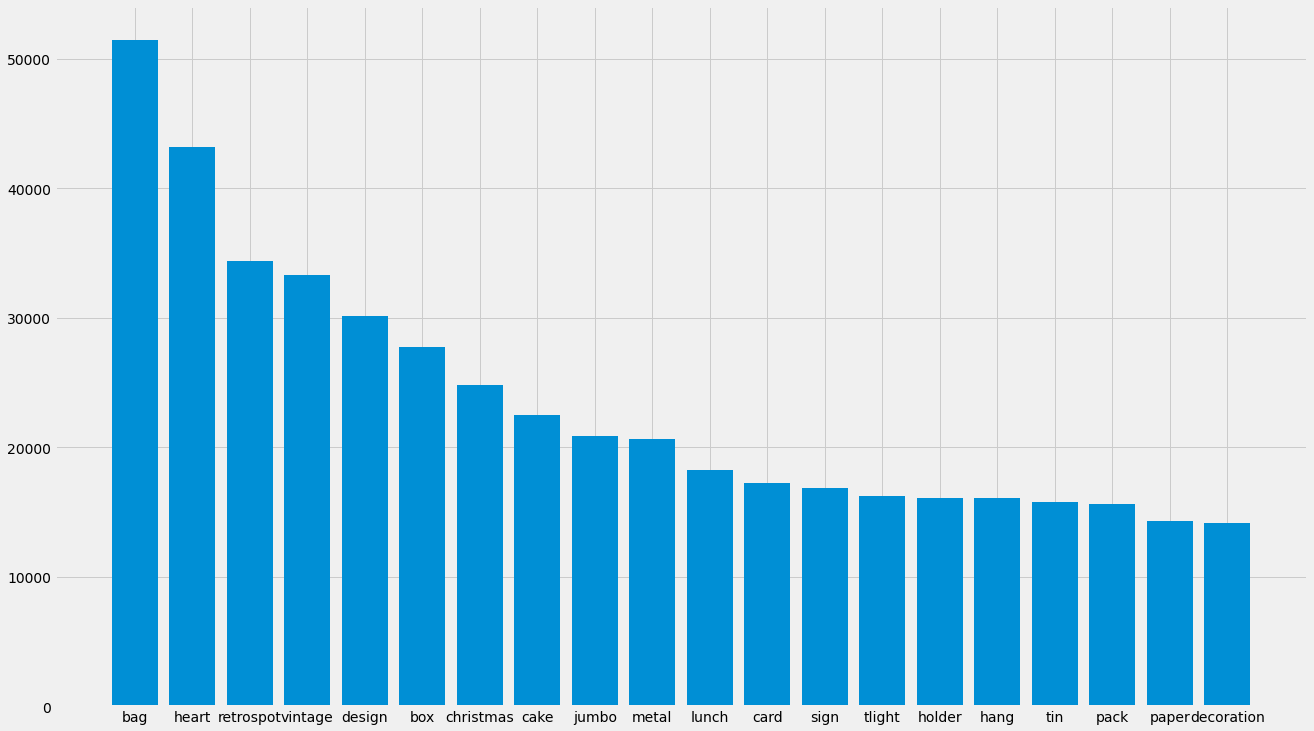

In [13]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())

{'poinsettia': 2, 'minicard': 2, 'necklaceleaf': 2, 'silt': 2, 'squ': 2, 'crome': 2, 'candleincense': 2, 'deck': 2, 'girly': 1, 'loveheart': 1, 'tinsel': 1, 'weekend': 1, 'blackchristmas': 1, 'boombox': 1, 'ipod': 1, 'demi': 1, 'choker': 1, 'opulent': 1, 'snowflakepink': 1, 'banner': 1, 'cutglass': 1, 'ooh': 1, 'bazaar': 1, 'mcolour': 1, 'bluenat': 1, 'scallop': 1, 'heavens': 1, 'fragrance': 1, 'guitar': 1, 'purpleturq': 1, 'sell': 1, 'barcode': 1, 'rcvd': 1, 'temp': 1, 'flowerbutterfly': 1, 'mummy': 1, 'tick': 1, 'ret': 1, 'orangefuschia': 1, 'antoienett': 1, 'laser': 1, 'haynes': 1, 'camper': 1, 'cargo': 1, 'whitesilver': 1, 'capiz': 1, 'incorrectly': 1, 'througha': 1, 'alan': 1, 'hodge': 1, 'mamage': 1, 'section': 1, 'beadshand': 1, 'fba': 1, 'branch': 1, 'teddycake': 1, 'add': 1, 'retail': 1, 'damage': 1, 'whse': 1, 'website': 1, 'draw': 1, 'trading': 1, 'zero': 1, 'invc': 1, 'incorr': 1, 'michel': 1, 'oops': 1, 'artonly': 1, 'partition': 1, 'panel': 1, 'error': 1, 'miror': 1, 'jac

<BarContainer object of 15 artists>

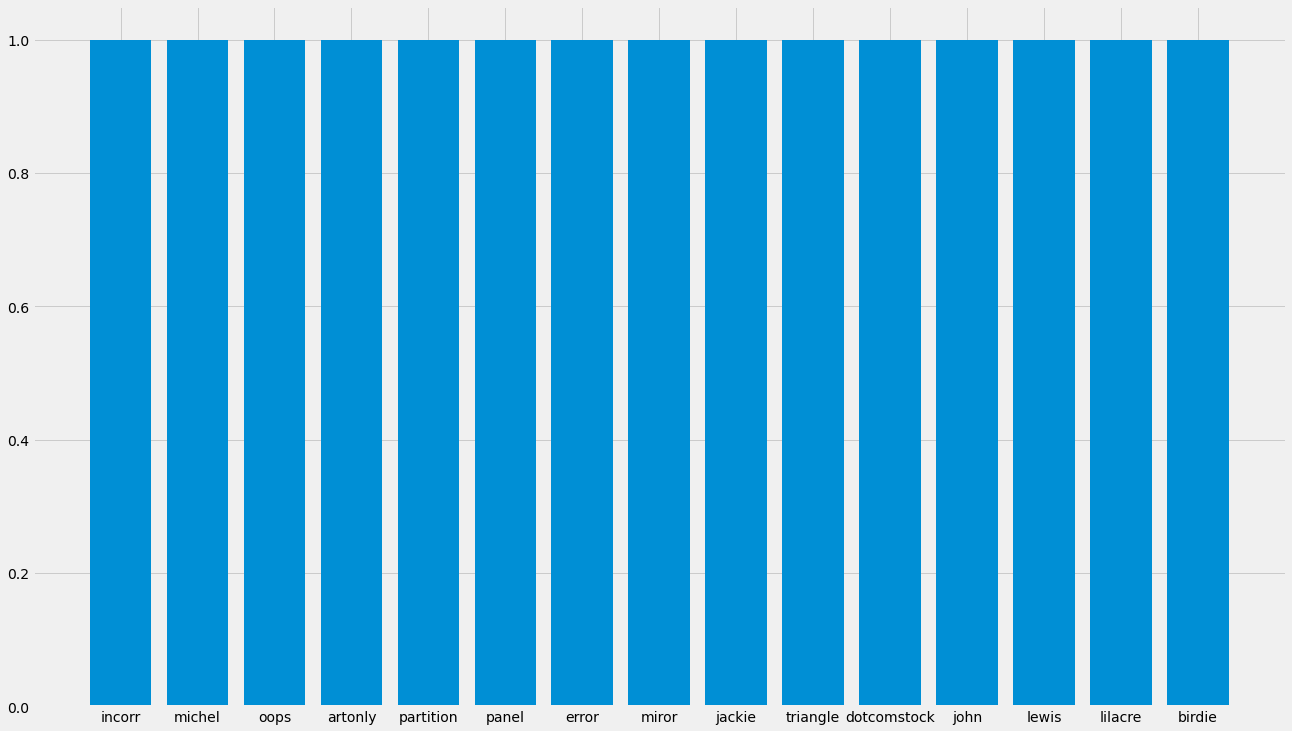

In [14]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-80:])
print(w)
w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-15:])
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())

In [15]:
%%time
# @formatter:on

model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('all-MiniLM-L6-v2')
corpus_sentences = list(df['DescriptionEdited'].unique())
corpus_embeddings = model.encode(corpus_sentences,
                                 batch_size = 64,
                                 show_progress_bar = True,
                                 convert_to_tensor = True)

print("Start clustering")
start_time = time.time()
# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least min_cluster_size elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings,
                                    min_community_size = 2,
                                    threshold = 0.85, )
print(f"Clustering done after {time.time() - start_time:.2f} sec")
print(f"Number of clusters: {len(clusters)}")

for i, cluster in enumerate(clusters):
    if i % 35 == 0:
        # The first element in each list is the central point in the community.
        print(f"Cluster {i + 1}, #{len(cluster)} Elements")
        for sentence_id in cluster[0:2]:
            print("\t", corpus_sentences[sentence_id])

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Start clustering
Clustering done after 0.29 sec
Number of clusters: 380
Cluster 1, #9 Elements
	 embroidered ribbon reel rebecca
	 embroidered ribbon reel rachel
Cluster 36, #4 Elements
	 vintage cutlery
	 vintage sky cutlery
Cluster 71, #3 Elements
	 home garland paint zinc
	 love garland paint zinc
Cluster 106, #2 Elements
	 wood cabinet ant finish
	 wood board ant finish
Cluster 141, #2 Elements
	 vintage union jack bunt
	 wooden union jack bunt
Cluster 176, #2 Elements
	 lipstick pen
	 lipstick pen baby
Cluster 211, #2 Elements
	 feel farm animal bunny
	 feel farm animal rabbit
Cluster 246, #2 Elements
	 turq stonecrystal earring
	 stonecrystal earring
Cluster 281, #2 Elements
	 easter decoration sit bunny
	 decoration sit bunny
Cluster 316, #2 Elements
	 marie antoinette trinket box
	 marie antoinette trinket box silver
Cluster 351, #2 Elements
	 love london mini backpack
	 love london mini rucksack
Wall time: 40.8 s


In [16]:
%%time
# @formatter:on

cluster_centers = []
for i, cluster in enumerate(clusters):
    cluster_sentences = []
    cluster_centers.append(corpus_embeddings[cluster[0]])
    for sentence_id in cluster:
        cluster_sentences.append(corpus_sentences[sentence_id])
    df.loc[df[df['DescriptionEdited'].isin(cluster_sentences)].index, 'ClusterId'] = i

null_val_summary(df = df)

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,object,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,394134
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.495484


Total Quantity of unclustered sales: 4361397, percentage: 77.26
Total Quantity*UnitPrice of unclustered sales: 7577240.89, percentage: 73.72
Wall time: 8.26 s


In [17]:
%%time
# @formatter:on

df['InvoiceNoNumQuantitySum'] = df.groupby('StockCodeNum')['Quantity'].transform(sum)
df['InvoiceNoNumTotalPriceSum'] = df.groupby('StockCodeNum')['TotalPrice'].transform(sum)

display(df.sort_values(by = ['InvoiceNoNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(15))
display(df.sort_values(by = ['InvoiceNoNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(15))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum
540421,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,581483,23843,,paper craft little birdie,paper craft little birdie,NaN,168469.60,80995,168469.60
255386,559341,85099b,jumbo bag red retrospot,10,2011-07-07 16:56:00,2.08,15144,United Kingdom,559341,85099,b,jumbo bag retrospot,jumbo bag retrospot,NaN,20.80,79823,155234.78
333318,566193,23166,medium ceramic top storage jar,12,2011-09-09 13:37:00,1.25,14961,United Kingdom,566193,23166,,ceramic storage jar,ceramic storage jar,NaN,15.00,78033,81700.92
191361,553351,22197,small popcorn holder,20,2011-05-16 13:35:00,0.85,18118,United Kingdom,553351,22197,,popcorn holder,popcorn holder,NaN,17.00,56921,51354.02
17324,537707,84077,world war 2 gliders asstd designs,48,2010-12-08 10:53:00,0.29,14032,United Kingdom,537707,84077,,world war glider asstd design,world war glider asstd design,NaN,13.92,55047,13841.85
313653,564530,85123a,white hanging heart t-light holder,1,2011-08-25 14:57:00,0.00,-1,United Kingdom,564530,85123,a,hang heart tlight holder,hang heart tlight holder,8.0,0.00,41956,106471.28
146776,549018,84879,assorted colour bird ornament,24,2011-04-05 15:21:00,1.69,17492,United Kingdom,549018,84879,,assorted colour bird ornament,assorted colour bird ornament,NaN,40.56,36461,59094.93
250392,559027,21212,pack of 72 retrospot cake cases,24,2011-07-05 14:24:00,0.55,17046,United Kingdom,559027,21212,,pack retrospot cake case,pack retrospot cake case,NaN,13.20,36419,21259.10
424694,573279,23084,rabbit night light,120,2011-10-28 13:22:00,1.79,16107,United Kingdom,573279,23084,,rabbit night light,rabbit night light,NaN,214.80,31722,66964.99
25332,538367,22492,mini paint set vintage,36,2010-12-12 10:48:00,0.65,14800,United Kingdom,538367,22492,,mini paint vintage,mini paint vintage,NaN,23.40,26633,16937.82


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum
88034,543754,22423,regency cakestand 3 tier,16,2011-02-11 14:26:00,10.95,18159,United Kingdom,543754,22423,,regency cakestand tier,regency cakestand tier,28.0,175.20,13890,174484.74
540421,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,581483,23843,,paper craft little birdie,paper craft little birdie,NaN,168469.60,80995,168469.60
476978,577043,85099b,jumbo bag red retrospot,10,2011-11-17 13:38:00,2.08,14282,United Kingdom,577043,85099,b,jumbo bag retrospot,jumbo bag retrospot,NaN,20.80,79823,155234.78
453971,575504,47566,party bunting,8,2011-11-10 10:29:00,4.95,14895,United Kingdom,575504,47566,,party bunting,party bunting,NaN,39.60,22180,112445.60
223434,556484,85123a,white hanging heart t-light holder,10,2011-06-12 13:17:00,2.95,16938,United Kingdom,556484,85123,a,hang heart tlight holder,hang heart tlight holder,8.0,29.50,41956,106471.28
188644,553052,23166,medium ceramic top storage jar,48,2011-05-13 10:14:00,1.04,15251,United Kingdom,553052,23166,,ceramic storage jar,ceramic storage jar,NaN,49.92,78033,81700.92
438181,574308,84997c,childrens cutlery polkadot blue,4,2011-11-03 16:45:00,4.15,16409,United Kingdom,574308,84997,c,children cutlery polkadot,children cutlery polkadot,109.0,16.60,16749,69181.42
210323,555278,23084,rabbit night light,3,2011-06-01 17:33:00,4.13,-1,United Kingdom,555278,23084,,rabbit night light,rabbit night light,NaN,12.39,31722,66964.99
336958,566420,22086,paper chain kit 50's christmas,2,2011-09-12 13:50:00,2.95,16360,United Kingdom,566420,22086,,paper chain kit christmas,paper chain kit christmas,104.0,5.90,19355,64952.29
256268,559469,84879,assorted colour bird ornament,8,2011-07-08 13:37:00,1.69,15182,United Kingdom,559469,84879,,assorted colour bird ornament,assorted colour bird ornament,NaN,13.52,36461,59094.93


Wall time: 1.21 s


In [18]:
%%time
# @formatter:on

stacked_centers = torch.stack(cluster_centers)
unclustered_df = df[df['ClusterId'].isna()]

for inx, row in tqdm(unclustered_df.iterrows()):
    df.loc[inx, 'ClusterId'] = torch.argmax(util.cos_sim(corpus_embeddings[corpus_sentences.index(row['DescriptionEdited'])],
                                                         stacked_centers)).item()

null_val_summary(df = df)

unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")

df['InvoiceNoNumQuantitySum'] = df.groupby('StockCodeNum')['Quantity'].transform(sum)
df['InvoiceNoNumTotalPriceSum'] = df.groupby('StockCodeNum')['TotalPrice'].transform(sum)

display(df.sort_values(by = ['InvoiceNoNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(15))
display(df.sort_values(by = ['InvoiceNoNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(15))


394134it [51:15, 128.17it/s]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,object,object,float64,float64,int64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Quantity of unclustered sales: 0, percentage: 0.00
Total Quantity*UnitPrice of unclustered sales: 0.00, percentage: 0.00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum
540421,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,581483,23843,,paper craft little birdie,paper craft little birdie,174.0,168469.60,80995,168469.60
255386,559341,85099b,jumbo bag red retrospot,10,2011-07-07 16:56:00,2.08,15144,United Kingdom,559341,85099,b,jumbo bag retrospot,jumbo bag retrospot,193.0,20.80,79823,155234.78
333318,566193,23166,medium ceramic top storage jar,12,2011-09-09 13:37:00,1.25,14961,United Kingdom,566193,23166,,ceramic storage jar,ceramic storage jar,320.0,15.00,78033,81700.92
191361,553351,22197,small popcorn holder,20,2011-05-16 13:35:00,0.85,18118,United Kingdom,553351,22197,,popcorn holder,popcorn holder,319.0,17.00,56921,51354.02
17324,537707,84077,world war 2 gliders asstd designs,48,2010-12-08 10:53:00,0.29,14032,United Kingdom,537707,84077,,world war glider asstd design,world war glider asstd design,116.0,13.92,55047,13841.85
313653,564530,85123a,white hanging heart t-light holder,1,2011-08-25 14:57:00,0.00,-1,United Kingdom,564530,85123,a,hang heart tlight holder,hang heart tlight holder,8.0,0.00,41956,106471.28
146776,549018,84879,assorted colour bird ornament,24,2011-04-05 15:21:00,1.69,17492,United Kingdom,549018,84879,,assorted colour bird ornament,assorted colour bird ornament,144.0,40.56,36461,59094.93
250392,559027,21212,pack of 72 retrospot cake cases,24,2011-07-05 14:24:00,0.55,17046,United Kingdom,559027,21212,,pack retrospot cake case,pack retrospot cake case,166.0,13.20,36419,21259.10
424694,573279,23084,rabbit night light,120,2011-10-28 13:22:00,1.79,16107,United Kingdom,573279,23084,,rabbit night light,rabbit night light,115.0,214.80,31722,66964.99
25332,538367,22492,mini paint set vintage,36,2010-12-12 10:48:00,0.65,14800,United Kingdom,538367,22492,,mini paint vintage,mini paint vintage,211.0,23.40,26633,16937.82


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum
88034,543754,22423,regency cakestand 3 tier,16,2011-02-11 14:26:00,10.95,18159,United Kingdom,543754,22423,,regency cakestand tier,regency cakestand tier,28.0,175.20,13890,174484.74
540421,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,581483,23843,,paper craft little birdie,paper craft little birdie,174.0,168469.60,80995,168469.60
476978,577043,85099b,jumbo bag red retrospot,10,2011-11-17 13:38:00,2.08,14282,United Kingdom,577043,85099,b,jumbo bag retrospot,jumbo bag retrospot,193.0,20.80,79823,155234.78
453971,575504,47566,party bunting,8,2011-11-10 10:29:00,4.95,14895,United Kingdom,575504,47566,,party bunting,party bunting,141.0,39.60,22180,112445.60
223434,556484,85123a,white hanging heart t-light holder,10,2011-06-12 13:17:00,2.95,16938,United Kingdom,556484,85123,a,hang heart tlight holder,hang heart tlight holder,8.0,29.50,41956,106471.28
188644,553052,23166,medium ceramic top storage jar,48,2011-05-13 10:14:00,1.04,15251,United Kingdom,553052,23166,,ceramic storage jar,ceramic storage jar,320.0,49.92,78033,81700.92
438181,574308,84997c,childrens cutlery polkadot blue,4,2011-11-03 16:45:00,4.15,16409,United Kingdom,574308,84997,c,children cutlery polkadot,children cutlery polkadot,109.0,16.60,16749,69181.42
210323,555278,23084,rabbit night light,3,2011-06-01 17:33:00,4.13,-1,United Kingdom,555278,23084,,rabbit night light,rabbit night light,115.0,12.39,31722,66964.99
336958,566420,22086,paper chain kit 50's christmas,2,2011-09-12 13:50:00,2.95,16360,United Kingdom,566420,22086,,paper chain kit christmas,paper chain kit christmas,104.0,5.90,19355,64952.29
256268,559469,84879,assorted colour bird ornament,8,2011-07-08 13:37:00,1.69,15182,United Kingdom,559469,84879,,assorted colour bird ornament,assorted colour bird ornament,144.0,13.52,36461,59094.93


Wall time: 51min 17s


In [19]:
%%time
# @formatter:on

df['ClusterIdQuantitySum'] = df.groupby('ClusterId')['Quantity'].transform(sum)
df['ClusterIdTotalPriceSum'] = df.groupby('ClusterId')['TotalPrice'].transform(sum)

display(df.sort_values(by = ['ClusterIdQuantitySum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(15))
display(df.sort_values(by = ['ClusterIdTotalPriceSum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(15))


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
379936,569718,23343,jumbo bag vintage christmas,10,2011-10-06 09:01:00,2.08,15837,United Kingdom,569718,23343,,jumbo bag vintage christmas,jumbo bag vintage christmas,37.0,20.80,9981,13978.95,134877,289922.17
50476,540551,22377,bottle bag retrospot,11,2011-01-10 09:43:00,1.66,-1,United Kingdom,540551,22377,,bottle bag retrospot,bottle bag retrospot,193.0,18.26,1330,2171.53,116072,221698.91
194037,553549,21908,chocolate this way metal sign,1,2011-05-17 16:09:00,4.13,-1,United Kingdom,553549,21908,,way metal sign,way metal sign,27.0,4.13,3773,7756.42,115260,220337.70
184679,552702,22983,card billboard font,1,2011-05-10 16:00:00,0.83,-1,United Kingdom,552702,22983,,card billboard font,card billboard font,174.0,0.83,5302,2261.60,115249,206393.50
199981,554108,22470,heart of wicker large,6,2011-05-22 14:29:00,2.95,13668,United Kingdom,554108,22470,,heart wicker,heart wicker,65.0,17.70,9904,30139.41,99203,165212.26
467461,576345,22956,36 foil heart cake cases,6,2011-11-14 15:37:00,2.10,12374,Austria,576345,22956,,foil heart cake case,foil heart cake case,137.0,12.60,2055,3992.58,96358,83671.17
535594,581217,22363,glass jar marmalade,1,2011-12-08 09:20:00,5.79,-1,United Kingdom,581217,22363,,glass jar marmalade,glass jar marmalade,320.0,5.79,484,1383.75,95128,116007.59
467033,576339,21983,pack of 12 blue paisley tissues,1,2011-11-14 15:27:00,0.83,14096,United Kingdom,576339,21983,,pack paisley tissue,pack paisley tissue,152.0,0.83,2301,777.67,87337,34337.43
300784,563213,21498,red retrospot wrap,25,2011-08-14 12:55:00,0.42,16115,United Kingdom,563213,21498,,retrospot wrap,retrospot wrap,116.0,10.50,10551,4322.42,79900,80975.57
96950,544597,85123a,white hanging heart t-light holder,3,2011-02-21 17:42:00,2.95,16014,United Kingdom,544597,85123,a,hang heart tlight holder,hang heart tlight holder,8.0,8.85,41956,106471.28,77096,170011.94


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
487313,577768,22374,airline bag vintage jet set red,1,2011-11-21 15:18:00,8.29,-1,United Kingdom,577768,22374,,airline bag vintage jet,airline bag vintage jet,37.0,8.29,555,2440.27,134877,289922.17
410698,572127,22114,hot water bottle tea and sympathy,8,2011-10-21 09:20:00,4.25,14911,EIRE,572127,22114,,hot water bottle tea sympathy,hot water bottle tea sympathy,14.0,34.00,5892,33002.59,49954,241315.61
22147,538153,22776,sweetheart cakestand 3 tier,2,2010-12-09 16:31:00,20.38,-1,United Kingdom,538153,22776,,sweetheart cakestand tier,sweetheart cakestand tier,28.0,40.76,1245,13088.73,23781,229367.58
86160,543536,85099b,jumbo bag red retrospot,5,2011-02-09 13:41:00,1.95,-1,United Kingdom,543536,85099,b,jumbo bag retrospot,jumbo bag retrospot,193.0,9.75,79823,155234.78,116072,221698.91
241314,558196,21908,chocolate this way metal sign,5,2011-06-27 12:38:00,2.10,16033,United Kingdom,558196,21908,,way metal sign,way metal sign,27.0,10.50,3773,7756.42,115260,220337.70
139285,548310,47566,party bunting,1,2011-03-30 12:04:00,4.95,-1,United Kingdom,548310,47566,,party bunting,party bunting,141.0,4.95,22180,112445.60,61877,211401.20
73250,542344,21993,floral folk stationery set,2,2011-01-27 11:30:00,2.46,-1,United Kingdom,542344,21993,,floral folk stationery,floral folk stationery,174.0,4.92,1943,3363.34,115249,206393.50
308915,564057,23342,mint diner wall clock,2,2011-08-22 14:20:00,8.50,15296,United Kingdom,564057,23342,,mint diner wall clock,mint diner wall clock,96.0,17.00,375,3193.41,38750,183843.14
461913,575955,85123a,white hanging heart t-light holder,3,2011-11-13 12:05:00,2.95,14044,United Kingdom,575955,85123,a,hang heart tlight holder,hang heart tlight holder,8.0,8.85,41956,106471.28,77096,170011.94
471838,576652,23332,ivory wicker heart large,3,2011-11-16 10:39:00,1.65,17198,United Kingdom,576652,23332,,wicker heart,wicker heart,65.0,4.95,2076,3570.76,99203,165212.26


Wall time: 1.22 s


In [20]:
%%time
# @formatter:on
clusters_df = pd.DataFrame()
for inx, df_cluster in df.groupby(['ClusterId']):
    clusters_df = clusters_df.append({'Id': int(inx),
                                      'Center': corpus_embeddings[clusters[int(inx)][0]].numpy(),
                                      'Detail': ' '.join(list(dict(Counter([i for j in df_cluster['DescriptionEdited'].str.split().tolist()
                                                                            for i in j]).most_common(5)).keys()))},
                                     ignore_index = True)
    if inx % 50 == 0:
        display(df_cluster.drop_duplicates(subset = ['DescriptionEdited']))

clusters_df.to_parquet(path = './data/retail-products-cluster-v1.parquet', engine = 'pyarrow')

# df1 = pd.read_parquet(path = './data/retail-products-cluster-v1.parquet', engine = 'pyarrow')
# df1['Center'] = df1['Center'].apply(lambda x: torch.from_numpy(x))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
244,536392,21891,traditional wooden skipping rope,12,2010-12-01 10:29:00,1.25,13705,United Kingdom,536392,21891,,traditional wooden skipping rope,traditional wooden skipping rope,0.0,15.00,8146,10526.00,24978,43702.43
478,536408,22736,ribbon reel making snowmen,10,2010-12-01 11:41:00,1.65,14307,United Kingdom,536408,22736,,ribbon reel make snowman,ribbon reel make snowman,0.0,16.50,1233,2315.25,24978,43702.43
626,536415,22738,ribbon reel snowy village,3,2010-12-01 11:57:00,1.65,12838,United Kingdom,536415,22738,,ribbon reel snowy village,ribbon reel snowy village,0.0,4.95,2189,3856.07,24978,43702.43
846,536464,22082,ribbon reel stripes design,5,2010-12-01 12:23:00,1.65,17968,United Kingdom,536464,22082,,ribbon reel stripe design,ribbon reel stripe design,0.0,8.25,2713,4716.33,24978,43702.43
793,536464,22737,ribbon reel christmas present,1,2010-12-01 12:23:00,1.65,17968,United Kingdom,536464,22737,,ribbon reel christmas present,ribbon reel christmas present,0.0,1.65,1389,2695.80,24978,43702.43
1499,536544,22081,ribbon reel flora + fauna,1,2010-12-01 14:32:00,3.36,-1,United Kingdom,536544,22081,,ribbon reel flora fauna,ribbon reel flora fauna,0.0,3.36,654,1193.00,24978,43702.43
1498,536544,22080,ribbon reel polkadots,1,2010-12-01 14:32:00,3.36,-1,United Kingdom,536544,22080,,ribbon reel polkadot,ribbon reel polkadot,0.0,3.36,1222,2028.23,24978,43702.43
2639,536592,22078,ribbon reel lace design,1,2010-12-01 17:06:00,4.21,-1,United Kingdom,536592,22078,,ribbon reel lace design,ribbon reel lace design,0.0,4.21,1385,2948.41,24978,43702.43
4582,536796,21268,vintage blue tinsel reel,2,2010-12-02 15:46:00,0.42,15574,United Kingdom,536796,21268,,vintage tinsel reel,vintage tinsel reel,0.0,0.84,2,0.84,24978,43702.43
7625,537047,22079,ribbon reel hearts design,1,2010-12-05 11:02:00,1.65,13069,United Kingdom,537047,22079,,ribbon reel heart design,ribbon reel heart design,0.0,1.65,1911,3348.39,24978,43702.43


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
742,536446,72800e,4 ivory dinner candles silver flock,6,2010-12-01 12:15:00,2.55,15983,United Kingdom,536446,72800,e,dinner candle silver flock,dinner candle silver flock,50.0,15.30,908,1998.13,2851,4613.8
1057,536522,72800b,4 purple flock dinner candles,2,2010-12-01 12:49:00,2.55,15012,United Kingdom,536522,72800,b,flock dinner candle,flock dinner candle,50.0,5.10,908,1998.13,2851,4613.8
1737,536544,72799f,ivory pillar candle gold flock,2,2010-12-01 14:32:00,3.36,-1,United Kingdom,536544,72799,f,pillar candle flock,pillar candle flock,50.0,6.72,678,1473.49,2851,4613.8
1736,536544,72799e,ivory pillar candle silver flock,2,2010-12-01 14:32:00,3.36,-1,United Kingdom,536544,72799,e,pillar candle silver flock,pillar candle silver flock,50.0,6.72,678,1473.49,2851,4613.8
1718,536544,35610a,pink christmas flock droplet,1,2010-12-01 14:32:00,2.51,-1,United Kingdom,536544,35610,a,christmas flock droplet,christmas flock droplet,50.0,2.51,59,77.53,2851,4613.8
3316,536620,21058,party invites woodland,12,2010-12-02 10:27:00,0.85,14135,United Kingdom,536620,21058,,party invite woodland,party invite woodland,50.0,10.20,1157,968.21,2851,4613.8
11264,537240,35833g,4 gold flock christmas balls,2,2010-12-06 10:08:00,3.36,-1,United Kingdom,537240,35833,g,flock christmas ball,flock christmas ball,50.0,6.72,52,96.44,2851,4613.8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
1307,536532,22494,emergency first aid tin,24,2010-12-01 13:24:00,1.25,12433,Norway,536532,22494,,emergency aid tin,emergency aid tin,100.0,30.00,1089,1573.52,6645,22787.48
1793,536544,85232b,set of 3 babushka stacking tins,1,2010-12-01 14:32:00,4.95,-1,United Kingdom,536544,85232,b,babushka stacking tin,babushka stacking tin,100.0,4.95,697,2748.27,6645,22787.48
1593,536544,22497,set of 2 tins vintage bathroom,2,2010-12-01 14:32:00,8.47,-1,United Kingdom,536544,22497,,tin vintage bathroom,tin vintage bathroom,100.0,16.94,225,1145.15,6645,22787.48
3012,536592,85232d,set/3 decoupage stacking tins,1,2010-12-01 17:06:00,10.17,-1,United Kingdom,536592,85232,d,decoupage stacking tin,decoupage stacking tin,100.0,10.17,697,2748.27,6645,22787.48
2614,536592,21906,pharmacie first aid tin,1,2010-12-01 17:06:00,13.57,-1,United Kingdom,536592,21906,,pharmacie aid tin,pharmacie aid tin,100.0,13.57,581,4470.81,6645,22787.48
25761,538397,22858,easter tin keepsake,42,2010-12-12 11:44:00,1.65,12753,Japan,538397,22858,,easter tin keepsake,easter tin keepsake,100.0,69.30,1129,1865.73,6645,22787.48
44521,540179,79071b,english rose metal waste bin,1,2011-01-05 12:54:00,2.95,16033,United Kingdom,540179,79071,b,english rise metal waste bin,english rise metal waste bin,100.0,2.95,20,59.00,6645,22787.48
183127,552647,23081,green metal box army supplies,2,2011-05-10 13:33:00,8.25,13012,United Kingdom,552647,23081,,metal box army supply,metal box army supply,100.0,16.50,484,4046.50,6645,22787.48
218408,556042,23236,doiley storage tin,2,2011-06-08 12:44:00,2.89,14367,United Kingdom,556042,23236,,doiley storage tin,doiley storage tin,100.0,5.78,2509,7106.21,6645,22787.48
290770,562417,23236,storage tin vintage doiley,1,2011-08-04 16:32:00,5.79,-1,United Kingdom,562417,23236,,storage tin vintage doiley,storage tin vintage doiley,100.0,5.79,2509,7106.21,6645,22787.48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
633,536415,22580,advent calendar gingham sack,1,2010-12-01 11:57:00,5.95,12838,United Kingdom,536415,22580,,advent calendar gingham sack,advent calendar gingham sack,150.0,5.95,1317,6860.09,6380,39462.96
991,536520,22904,calendar paper cut design,3,2010-12-01 12:43:00,2.95,14729,United Kingdom,536520,22904,,calendar paper cut design,calendar paper cut design,150.0,8.85,1838,5479.06,6380,39462.96
992,536520,22905,calendar in season design,2,2010-12-01 12:43:00,2.95,14729,United Kingdom,536520,22905,,calendar season design,calendar season design,150.0,5.90,582,1505.24,6380,39462.96
1182,536529,22947,wooden advent calendar red,2,2010-12-01 13:20:00,16.95,14237,United Kingdom,536529,22947,,wooden advent calendar,wooden advent calendar,150.0,33.90,751,8714.24,6380,39462.96
1196,536530,22120,welcome wooden block letters,1,2010-12-01 13:21:00,9.95,17905,United Kingdom,536530,22120,,welcome wooden block letter,welcome wooden block letter,150.0,9.95,526,5276.94,6380,39462.96
1323,536535,22119,peace wooden block letters,3,2010-12-01 13:38:00,6.95,15605,United Kingdom,536535,22119,,peace wooden block letter,peace wooden block letter,150.0,20.85,351,1766.57,6380,39462.96
1322,536535,22121,noel wooden block letters,3,2010-12-01 13:38:00,5.95,15605,United Kingdom,536535,22121,,noel wooden block letter,noel wooden block letter,150.0,17.85,406,2165.65,6380,39462.96
2235,536569,22946,wooden advent calendar cream,1,2010-12-01 15:35:00,16.95,16274,United Kingdom,536569,22946,,wooden advent calendar cream,wooden advent calendar cream,150.0,16.95,454,7047.17,6380,39462.96
14890,537624,22903,calendar family favourites,1,2010-12-07 14:41:00,2.95,12748,United Kingdom,537624,22903,,calendar family favourite,calendar family favourite,150.0,2.95,193,550.60,6380,39462.96
36327,539450,35400,wooden box advent calendar,1,2010-12-17 16:53:00,8.95,15570,United Kingdom,539450,35400,,wooden box advent calendar,wooden box advent calendar,150.0,8.95,18,89.50,6380,39462.96


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
1416,536540,85136a,yellow shark helicopter,2,2010-12-01 14:05:00,7.95,14911,EIRE,536540,85136,a,shark helicopter,shark helicopter,200.0,15.90,126,1017.44,7869,11765.43
1415,536540,85135b,blue dragonfly helicopter,2,2010-12-01 14:05:00,7.95,14911,EIRE,536540,85135,b,dragonfly helicopter,dragonfly helicopter,200.0,15.90,300,1531.98,7869,11765.43
3648,536638,21390,filigris heart with butterfly,24,2010-12-02 11:41:00,1.25,16244,United Kingdom,536638,21390,,filigris heart butterfly,filigris heart butterfly,200.0,30.00,3906,4851.88,7869,11765.43
8935,537156,75013b,"string of 8 butterflies,pink",4,2010-12-05 13:08:00,1.65,17858,United Kingdom,537156,75013,b,string butterfliespink,string butterfliespink,200.0,6.60,27,41.25,7869,11765.43
29820,538827,75178,asstd col butterfly/crystal w/chime,144,2010-12-14 12:59:00,0.42,14298,United Kingdom,538827,75178,,asstd col butterflycrystal wchime,asstd col butterflycrystal wchime,200.0,60.48,459,218.87,7869,11765.43
81335,543121,90098,necklace+bracelet pink butterfly,6,2011-02-03 13:58:00,2.55,12662,Germany,543121,90098,,necklacebracelet butterfly,necklacebracelet butterfly,200.0,15.30,29,73.95,7869,11765.43
205099,554708,23228,filigree heart bird white,24,2011-05-26 10:25:00,1.25,16449,United Kingdom,554708,23228,,filigree heart bird,filigree heart bird,200.0,30.00,1492,1960.00,7869,11765.43
205302,554788,23227,filigree heart butterfly white,24,2011-05-26 12:00:00,1.25,12987,United Kingdom,554788,23227,,filigree heart butterfly,filigree heart butterfly,200.0,30.00,1642,2070.06,7869,11765.43


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
12310,537374,79051a,smokey grey colour d.o.f. glass,4,2010-12-06 12:55:00,0.65,17259,United Kingdom,537374,79051,a,smokey colour dof glass,smokey colour dof glass,250.0,2.60,831,293.31,1119,1027.71
58121,541220,20914,set/5 red spotty lid glass bowls,288,2011-01-14 14:11:00,2.55,14156,EIRE,541220,20914,,spotty lid glass bowl,spotty lid glass bowl,250.0,734.40,6372,18390.20,1119,1027.71
365450,568709,79051a,smokey grey colour glass,8,2011-09-28 15:42:00,0.29,15036,United Kingdom,568709,79051,a,smokey colour glass,smokey colour glass,250.0,2.32,831,293.31,1119,1027.71


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
43,536370,22544,mini jigsaw spaceboy,24,2010-12-01 08:45:00,0.42,12583,France,536370,22544,,mini jigsaw spaceboy,mini jigsaw spaceboy,300.0,10.08,4521,1716.18,29162,57770.85
405,536404,22964,3 piece spaceboy cookie cutter set,12,2010-12-01 11:29:00,2.10,16218,United Kingdom,536404,22964,,piece spaceboy cookie cutter,piece spaceboy cookie cutter,300.0,25.20,2628,5481.09,29162,57770.85
447,536408,84375,set of 20 kids cookie cutters,12,2010-12-01 11:41:00,2.10,14307,United Kingdom,536408,84375,,kids cookie cutter,kids cookie cutter,300.0,25.20,4322,9404.15,29162,57770.85
652,536415,22367,childrens apron spaceboy design,3,2010-12-01 11:57:00,1.95,12838,United Kingdom,536415,22367,,childrens apron spaceboy design,childrens apron spaceboy design,300.0,5.85,3758,7520.28,29162,57770.85
1418,536540,21055,tool box soft toy,4,2010-12-01 14:05:00,8.95,14911,EIRE,536540,21055,,tool box soft toy,tool box soft toy,300.0,35.80,180,1782.54,29162,57770.85
1568,536544,22380,toy tidy spaceboy,1,2010-12-01 14:32:00,4.21,-1,United Kingdom,536544,22380,,toy tidy spaceboy,toy tidy spaceboy,300.0,4.21,1317,2823.86,29162,57770.85
4595,536796,21026,space owl,1,2010-12-02 15:46:00,1.25,15574,United Kingdom,536796,21026,,space owl,space owl,300.0,1.25,258,319.50,29162,57770.85
18865,537823,22541,mini jigsaw leap frog,1,2010-12-08 14:25:00,0.85,-1,United Kingdom,537823,22541,,mini jigsaw leap frog,mini jigsaw leap frog,300.0,0.85,504,202.37,29162,57770.85
97479,544634,84997b,childrens cutlery retrospot red,2,2011-02-22 11:02:00,4.15,17994,United Kingdom,544634,84997,b,children cutlery retrospot,children cutlery retrospot,300.0,8.30,16749,69181.42,29162,57770.85
148425,549238,23256,childrens cutlery spaceboy,2,2011-04-07 11:30:00,4.15,14667,United Kingdom,549238,23256,,children cutlery spaceboy,children cutlery spaceboy,300.0,8.30,2115,8675.37,29162,57770.85


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,DescriptionEdited,DescriptionEditedTemp,ClusterId,TotalPrice,InvoiceNoNumQuantitySum,InvoiceNoNumTotalPriceSum,ClusterIdQuantitySum,ClusterIdTotalPriceSum
605,536412,22902,tote bag i love london,7,2010-12-01 11:49:00,2.10,17920,United Kingdom,536412,22902,,tote bag love london,tote bag love london,350.0,14.70,1296,2650.08,5278,5957.43
1820,536544,84536a,english rose notebook a7 size,3,2010-12-01 14:32:00,0.85,-1,United Kingdom,536544,84536,a,english rise notebook size,english rise notebook size,350.0,2.55,5259,2313.15,5278,5957.43
8609,537140,84874b,blue travel first aid kit,1,2010-12-05 12:53:00,1.65,12748,United Kingdom,537140,84874,b,travel aid kit,travel aid kit,350.0,1.65,41,67.51,5278,5957.43
334343,566240,23391,i love london mini backpack,1,2011-09-11 11:29:00,4.15,14508,United Kingdom,566240,23391,,love london mini backpack,love london mini backpack,350.0,4.15,390,1632.32,5278,5957.43
379954,569720,23391,i love london mini rucksack,1,2011-10-06 09:11:00,4.15,14646,Netherlands,569720,23391,,love london mini rucksack,love london mini rucksack,350.0,4.15,390,1632.32,5278,5957.43


Wall time: 2.45 s


In [21]:
%%time
# @formatter:on


Wall time: 0 ns
